In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Load data

In [21]:


test_interval = 100

res = {}
for test_ind in range(1, 220):
    epoch = int(test_ind * test_interval)
    df = pd.read_csv(f'../data/staghunt_small_room_size7_regen1_v2_test_interval10_20251023-125008/unit_test/probe_test_epoch_{epoch}_group.csv')
    for col in df.columns[3:]:
        if test_ind == 1:
            res[col] = [df[col].mean()]
        else:
            res[col].append(df[col].mean())
res = pd.DataFrame(res)

In [18]:
folders = [
    'staghunt_small_room_size1_regen1_v2_test_interval10_20251023-124930',
    'staghunt_small_room_size3_regen1_v2_test_interval10_20251023-124949',
    'staghunt_small_room_size7_regen1_v2_test_interval10_20251023-125008'
]

test_interval = 100
num_tests = 2200

res = {'room_size': [], 'test_ind': []}
room_size = [1, 3, 7]
for idx, folder in enumerate(folders):
    for test_ind in range(1, num_tests):
        epoch = int(test_ind * test_interval)
        df = pd.read_csv(f'../data/{folder}/unit_test/probe_test_epoch_{epoch}_group.csv')
        for col in df.columns[3:]:
            if test_ind == 1 and idx == 0:
                res[col] = [df[col].mean()]
            else:
                res[col].append(df[col].mean())
    res['test_ind'].extend([x for x in range(1, num_tests)])
    res['room_size'].extend([room_size[idx]] * (num_tests - 1))
res = pd.DataFrame(res)


In [22]:
folders = [
    'test_oct28_20251028-001430'
]

test_interval = 100
num_tests = 1900

res = {'test_ind': []}
for idx, folder in enumerate(folders):
    for test_ind in range(1, num_tests):
        agent_data = {}
        for agent_ind in range(0, 3):
            epoch = int(test_ind * test_interval)
            df = pd.read_csv(f'../data/{folder}/unit_test/probe_test_epoch_{epoch}_agent_{agent_ind}.csv')
            for col in df.columns[4:]:
                if agent_ind == 0:
                    agent_data[col] = [df[col].mean()]
                else:
                    agent_data[col].append(df[col].mean())
        if test_ind == 1:
            for key, item in agent_data.items():
                res[key] = [np.mean(item)]
        else:
            for key, item in agent_data.items():
                res[key].append(np.mean(item))
                
        
    res['test_ind'].extend([x for x in range(1, num_tests)])
res = pd.DataFrame(res)

In [171]:
folders = [
    #'test_oct29_20251029-014636'
    #"test_oct29_regen0.25_20251029-112631"
    #"test_oct31_1a_20251030-174908"
    #"test_oct31_20251030-174452"
    #"test_oct31_3a_area_attack_20251031-005943"
    "test_area_attack_3a_Nov03_with_epsilon1_20251103-150916"
    #"test_area_attack_3a_Nov03_with_epsilon0_20251103-150829"
    #"test_line_attack_3a_Nov03_with_epsilon1_20251103-150942"
    #"test_line_attack_3a_Nov03_with_epsilon0_20251103-150759"
]

test_interval = 100
num_tests = 300
num_a = 3

res = {'test_ind': []}
for idx, folder in enumerate(folders):
    for test_ind in range(1, num_tests):
        agent_data = {}
        for agent_ind in range(0, num_a):
            for cond in ['upper', 'lower']:
                epoch = int(test_ind * test_interval)
                df = pd.read_csv(f'../data/{folder}/unit_test/test_intention_epoch_{epoch}_agent_{agent_ind}_{cond}.csv')
                for col in df.columns[2:]:
                    if col not in list(agent_data.keys()):
                        agent_data[col] = [df[col].mean()]
                    else:
                        agent_data[col].append(df[col].mean())
        if test_ind == 1:
            for key, item in agent_data.items():
                res[key] = [np.mean(item)]
        else:
            for key, item in agent_data.items():
                res[key].append(np.mean(item))
                
        
    res['test_ind'].extend([x for x in range(1, num_tests)])
res = pd.DataFrame(res)

In [46]:
res.columns

Index(['test_ind', 'q_val_forward', 'q_val_backward', 'q_val_step_left',
       'q_val_step_right', 'q_val_attack', 'weight_facing_stag',
       'weight_facing_hare'],
      dtype='object')

# Add rolling metrics

In [ ]:
# add rolling metrics
metrics = ['attacks_to_hares',
       'attacks_to_stags', 'punishments_given', 'punishments_received',
       'total_reward', 'attack_cost_paid', 'punish_cost_paid',
       'resources_defeated', 'stags_defeated', 'hares_defeated',
       'shared_rewards_received', 'stag_to_hare_ratio']
wsize = 1
res_rolling = res.copy()
# add stag-to-hare ratio
res_rolling['stag_to_hare_ratio'] = res_rolling['attacks_to_stags']/res_rolling['attacks_to_hares']
for metric in metrics:
    res_rolling[f'{metric}_rolling'] = res_rolling.groupby('room_size')[metric].rolling(wsize).mean().reset_index(drop=True)

In [30]:
# add rolling metrics
metrics = ['attacks_to_hares',
       'attacks_to_stags', 'punishments_given', 'punishments_received',
       'total_reward', 'attack_cost_paid', 'punish_cost_paid',
       'resources_defeated', 'stags_defeated', 'hares_defeated',
       'shared_rewards_received', 'stag_to_hare_ratio']
wsize = 20
res_rolling = res.copy()
# add stag-to-hare ratio
res_rolling['stag_to_hare_ratio'] = res_rolling['attacks_to_stags']/res_rolling['attacks_to_hares']
for metric in metrics:
    res_rolling[f'{metric}_rolling'] = res_rolling[metric].rolling(wsize).mean().reset_index(drop=True)

In [172]:
metrics = ['q_val_forward', 'q_val_backward', 'q_val_step_left',
       'q_val_step_right', 'q_val_attack', 'weight_facing_stag',
       'weight_facing_hare', 'ratio_facing_stag_vs_hare']
wsize = 5
res_rolling = res.copy()
res_rolling['ratio_facing_stag_vs_hare'] = res_rolling['weight_facing_stag']/res_rolling['weight_facing_hare']
for metric in metrics:
    res_rolling[f'{metric}_rolling'] = res_rolling[metric].rolling(wsize).mean().reset_index(drop=True)
    

In [66]:
res_rolling

,test_ind,q_val_forward,q_val_backward,q_val_step_left,q_val_step_right,q_val_attack,weight_facing_stag,weight_facing_hare,ratio_facing_stag_vs_hare,q_val_forward_rolling,q_val_backward_rolling,q_val_step_left_rolling,q_val_step_right_rolling,q_val_attack_rolling,weight_facing_stag_rolling,weight_facing_hare_rolling,ratio_facing_stag_vs_hare_rolling
0,1,-0.009084,-0.005997,-0.009960,-0.006390,0.149917,0.193531,0.193107,1.002193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.039430,0.043994,0.030659,0.037281,0.284799,0.188531,0.188727,0.998961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.295946,0.301402,0.313235,0.320247,0.523348,0.192592,0.192407,1.000960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0.331364,0.323723,0.337175,0.354823,0.547213,0.192819,0.192785,1.000175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0.647492,0.642889,0.644121,0.653816,0.914899,0.188729,0.188848,0.999368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,535,10.604268,10.319704,10.584638,10.708913,10.986836,0.199808,0.192102,1.040115,10.604916,10.148807,10.635723,10.457858,10.908697,0.191605,0.196562,0.977365
535,536,10.723836,10.422985,10.795892,10.772673,11.096249,0.194611,0.203557,0.956055,10.617035,10.182575,10.642625,10.498041,10.933722,0.192021,0.195468,0.984180
536,537,10.467901,10.061881,10.434970,10.587044,10.739657,0.199558,0.210002,0.950267,10.595300,10.165923,10.600105,10.511836,10.907858,0.192278,0.196524,0.980437
537,538,10.391902,10.148552,10.473289,10.464090,10.851322,0.186061,0.202937,0.916839,10.586790,10.161850,10.592481,10.521342,10.893912,0.192471,0.198671,0.970653


# Plot

<Axes: xlabel='test_ind', ylabel='weight_facing_hare_rolling'>

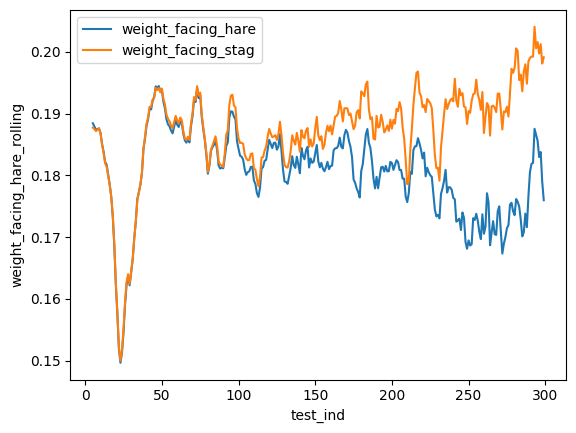

In [173]:
sns.lineplot(x = 'test_ind', y='weight_facing_hare_rolling', data=res_rolling, label='weight_facing_hare')
sns.lineplot(x = 'test_ind', y='weight_facing_stag_rolling', data=res_rolling, label='weight_facing_stag')


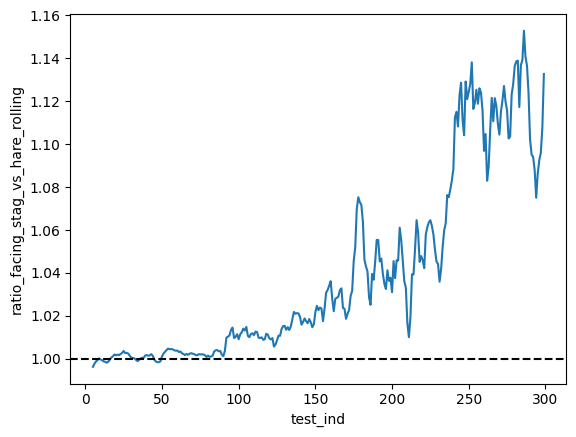

In [174]:
# line plot with sns
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling)
plt.axhline(y=1, color='black', linestyle='--')
# plt.ylim(0.999, 1.001)

In [27]:
# line plot with sns
sns.lineplot(x = 'test_ind', y='hares_defeated_rolling', hue='room_size', data=res_rolling)

ValueError: Could not interpret value `room_size` for `hue`. An entry with this name does not appear in `data`.

In [6]:
res_rolling

,room_size,test_epoch,attacks_to_hares,attacks_to_stags,punishments_given,punishments_received,total_reward,attack_cost_paid,punish_cost_paid,resources_defeated,...,attacks_to_stags_rolling,punishments_given_rolling,punishments_received_rolling,total_reward_rolling,attack_cost_paid_rolling,punish_cost_paid_rolling,resources_defeated_rolling,stags_defeated_rolling,hares_defeated_rolling,shared_rewards_received_rolling
0,1,2.0,4.200000,0.266667,3.600000,3.600000,-0.673333,0.0,1.093333,4.200000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2.0,2.466667,2.200000,3.800000,3.800000,-0.833333,0.0,1.080000,2.466667,...,1.233333,3.700000,3.700000,-0.753333,0.0,1.086667,3.333333,0.000000,3.333333,0.201667
2,1,2.0,3.266667,4.200000,3.266667,3.266667,-0.726667,0.0,1.053333,3.266667,...,3.200000,3.533333,3.533333,-0.780000,0.0,1.066667,2.866667,0.000000,2.866667,0.171111
3,1,2.0,3.133333,5.266667,4.000000,4.000000,-0.773333,0.0,1.120000,3.466667,...,4.733333,3.633333,3.633333,-0.750000,0.0,1.086667,3.366667,0.166667,3.200000,0.184444
4,1,2.0,3.333333,1.666667,4.333333,4.333333,-0.640000,0.0,1.006667,3.666667,...,3.466667,4.166667,4.166667,-0.706667,0.0,1.063333,3.566667,0.333333,3.233333,0.211111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,7,2.0,1.000000,15.800000,0.600000,0.600000,-0.046667,0.0,0.146667,1.000000,...,18.233333,0.966667,0.966667,-0.080000,0.0,0.193333,1.133333,0.000000,1.133333,0.068333
653,7,2.0,0.733333,0.933333,1.200000,1.200000,-0.046667,0.0,0.146667,1.000000,...,8.366667,0.900000,0.900000,-0.046667,0.0,0.146667,1.000000,0.133333,0.866667,0.063889
654,7,2.0,1.133333,1.133333,2.333333,2.333333,-0.680000,0.0,0.793333,1.133333,...,1.033333,1.766667,1.766667,-0.363333,0.0,0.470000,1.066667,0.133333,0.933333,0.071111
655,7,2.0,1.800000,0.000000,1.200000,1.200000,-0.140000,0.0,0.320000,1.800000,...,0.566667,1.766667,1.766667,-0.410000,0.0,0.556667,1.466667,0.000000,1.466667,0.090556


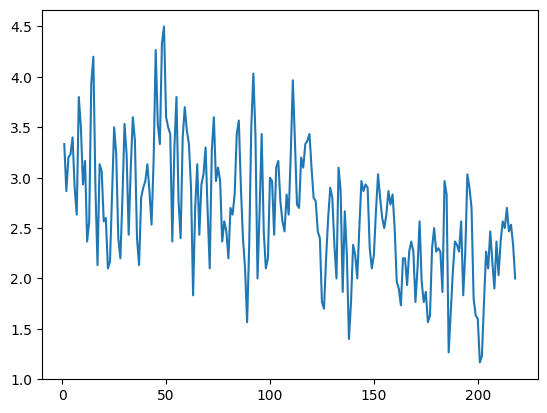

In [15]:
plt.plot(res['attacks_to_hares'].rolling(2).mean())

In [18]:
res.columns

Index(['test_epoch', 'attacks_to_hares', 'attacks_to_stags',
       'punishments_given', 'punishments_received', 'total_reward',
       'attack_cost_paid', 'punish_cost_paid', 'resources_defeated',
       'stags_defeated', 'hares_defeated', 'shared_rewards_received'],
      dtype='object')

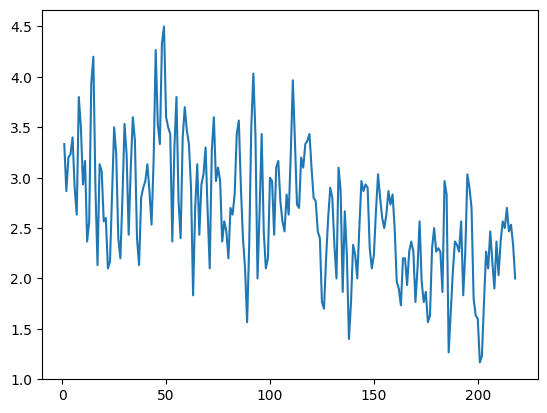

In [21]:
plt.plot(res['hares_defeated'].rolling(2).mean())